# Clustering Notebook for Doc2Vec
#### Author: Andrew Auyeung
The goal of this notebook is to find clusters in the TDS Doc2Vec vectors. 
Each proccess will generate subsamples of the dataset and try different hyperparameter tuning of the model. 

In [253]:
# Load Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from gensim.models.doc2vec import Doc2Vec
from vis_util import *
from collections import Counter


In [254]:
import csv
# Helper function to write by row to csv
def write_to_csv(doc, filepath, delimiter='\t'):
    with open(filepath, 'w') as to_write:
        writer = csv.writer(to_write, delimiter=delimiter)
        writer.writerows(doc)

In [255]:
# Load Model
model = Doc2Vec.load('../models/d2v_v5.model')

In [256]:
# Load articles
articles = pd.read_csv('../src/TDS_articles.csv', sep='\t', index_col=0)

In [294]:
nmf_topics = pd.read_csv('../src/nmf_topics.csv', index_col=0)
nmf_topics.set_index('article_id', inplace=True)

In [300]:
nmf_topics.loc[int(model.docvecs.index_to_doctag(0))][0]

18

### Helper Functions to assist in visualizing cluster unity

The document vectors are stored in the model in a 35000 x 300 array. 
Each vector is tagged with the article_id that associataes back to the article information in the *articles* dataframe.
To check if the topics are clustered similarly, we need to generate a list of the document titles indexed in the same order as the document vectors. 


In [282]:
titles_ = []
for idx in range(len(model.docvecs.vectors_docs)):
    titles_.append(articles.loc[int(model.docvecs.index_to_doctag(idx))]['title'])
titles_ = np.array(titles_)

## KMeans Hyperparameter Tuning
* Finding a good elbow 
* Using NLTK Kmeans to allow for cosine metric

In [265]:
from nltk.cluster import KMeansClusterer, cosine_distance
from sklearn.model_selection import ShuffleSplit

In [266]:
def kmeans_inertia(X, clusters):
    """
    Calculate Kmeans Inertia for nltk's clustering
    """
    sum_ = []
    for i in np.unique(clusters):
        ith_cluster = X[clusters==i] # get vectors in the current cluster
        centroid = np.mean(ith_cluster, axis=0) # calculate centroid for that cluster
        sum_.append(np.sum(np.sum((ith_cluster - centroid)**2, axis=1), axis=0)) # append sum of inertia for that cluster to sum list
    return np.sum(sum_)

In [267]:
train = model.docvecs.vectors_docs

In [268]:
train.shape

(35623, 100)

In [270]:
max_means = 50
# Set up Shuffle Split to randomly sample training data for the iteration 
shuffle = ShuffleSplit(n_splits=max_means, train_size=0.25, test_size=None).split(train)
inertias = []
silhouette_scores = []
for n in range(2, max_means):
    idx, _ = next(shuffle)
    clusterer = KMeansClusterer(num_means=n, distance=cosine_distance, repeats=5)
    clusters = np.array(clusterer.cluster(train[idx], True))
    print('Clusters Found, Calculating Inertias...')
    inertias.append(kmeans_inertia(train[idx], clusters))
    print('Calculting Silhouette Scores...')
    avg_score = np.mean(silhouette_samples(X=train[idx], labels=clusters.reshape(-1,1), metric='cosine'))
    silhouette_scores.append(avg_score)
    print(f"Finished finding Clusters for {n} means.\nCurrent Inertia Score was {inertias[-1]}\nCurrent Silhouette Score was {avg_score}")

Clusters Found, Calculating Inertias...
Calculting Silhouette Scores...
Finished finding Clusters for 2 means.
Current Inertia Score was 2126217.5
Current Silhouette Score was 0.06849188357591629
Clusters Found, Calculating Inertias...
Calculting Silhouette Scores...
Finished finding Clusters for 3 means.
Current Inertia Score was 2074758.75
Current Silhouette Score was 0.06963247805833817
Clusters Found, Calculating Inertias...
Calculting Silhouette Scores...
Finished finding Clusters for 4 means.
Current Inertia Score was 2012384.375
Current Silhouette Score was 0.07473547011613846
Clusters Found, Calculating Inertias...
Calculting Silhouette Scores...
Finished finding Clusters for 5 means.
Current Inertia Score was 1992592.75
Current Silhouette Score was 0.07345841079950333
Clusters Found, Calculating Inertias...
Calculting Silhouette Scores...
Finished finding Clusters for 6 means.
Current Inertia Score was 1970772.25
Current Silhouette Score was 0.07094692438840866
Clusters Found,

KeyboardInterrupt: 

Text(0.5, 1.0, 'Separation of Clusters from KMeans')

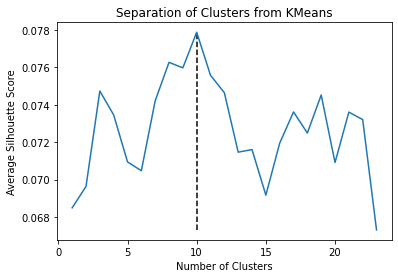

In [278]:
plt.plot(np.arange(1, len(silhouette_scores)+1), silhouette_scores)
plt.vlines(x=10, linestyles='--', ymin=min(silhouette_scores), ymax=max(silhouette_scores))

plt.xlabel('Number of Clusters')
plt.ylabel('Average Silhouette Score')
plt.title('Separation of Clusters from KMeans')

Text(0.5, 1.0, 'Elbow check for KMeans Neighbors')

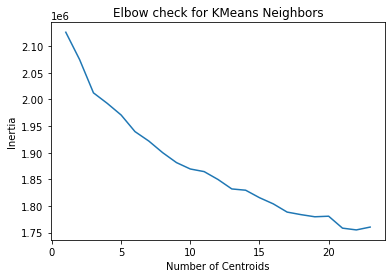

In [271]:
plt.plot(np.arange(1, len(inertias)+1), inertias)
plt.xlabel('Number of Centroids')
plt.ylabel('Inertia')
plt.title('Elbow check for KMeans Neighbors')

In [283]:
clusterer = KMeansClusterer(num_means=10, distance=cosine_distance, repeats=5)

In [284]:
clusters = np.array(clusterer.cluster(train, True))

In [285]:
clusters

array([4, 6, 4, ..., 2, 3, 9])

In [167]:
write_to_csv(clusters.reshape(-1,1), '../src/kmeans10.csv')

In [172]:
from sklearn.decomposition import PCA
pca_feat = PCA(2).fit_transform(train)

The average silhouette score is 0.03545653820037842


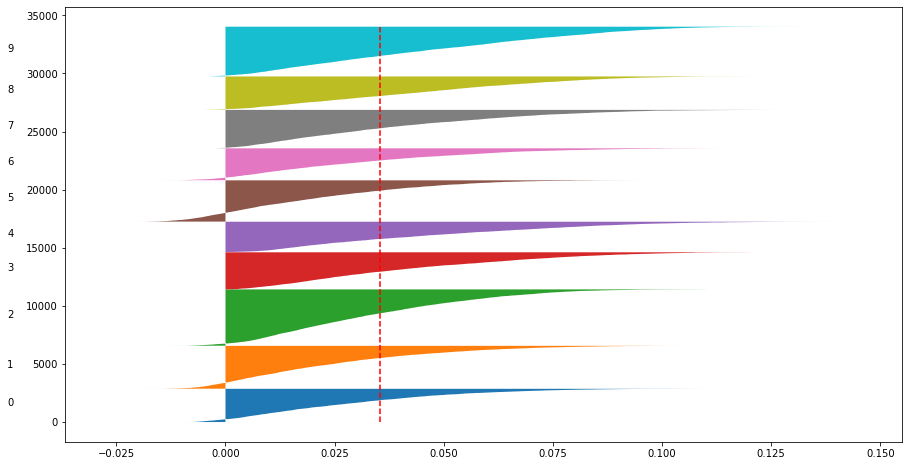

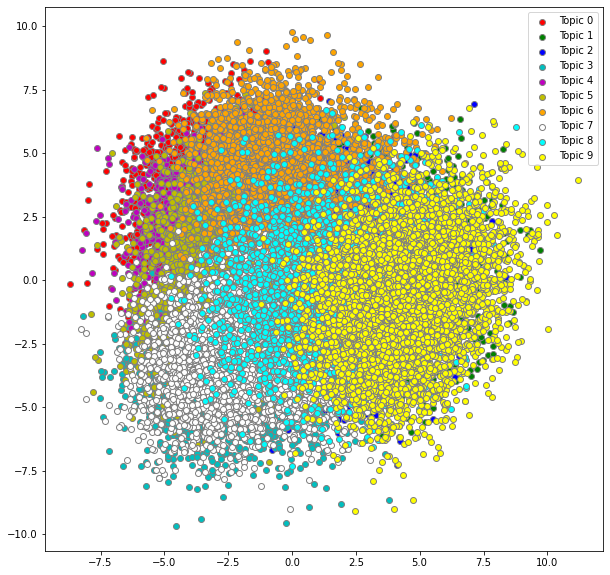

In [173]:
plot_silhouette(train, clusters, metric='cosine')
plot_PCA_2D(pca_feat, clusters)

In [ ]:
centroids = []

for i in np.unique(clusters):
    centroids.append(np.mean(train[clusters == i], axis=0))

In [75]:
def KMeans_titles(clusters, n=10):
    for c in np.unique(clusters):
        print(f'Cluster {c}')
        print('\n'.join(np.random.choice(titles_[clusters==c], n)))
        print('\n')

In [347]:
cluster_dicts = []
for idx, cluster in enumerate(clusters):
    article_id = int(model.docvecs.index_to_doctag(idx))
    topic = nmf_topics.loc[article_id][0]
    row = {
        'article_id': article_id,
        'cluster': cluster,
        'topic': topic
    }
    cluster_dicts.append(row)

In [348]:
kmeans_df = pd.DataFrame(cluster_dicts)

In [350]:
kmeans_df.to_csv('../src/article_cluster_topic.csv')

In [341]:
kmeans_df[kmeans_df.cluster==6].topic.value_counts().head(3)

5     909
10    431
8     311
Name: topic, dtype: int64

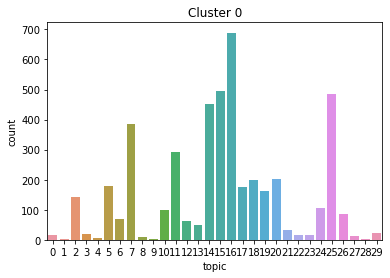

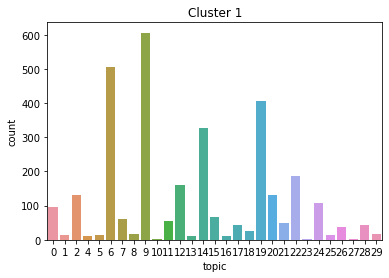

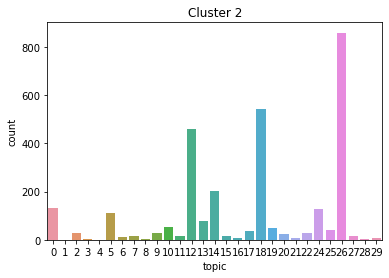

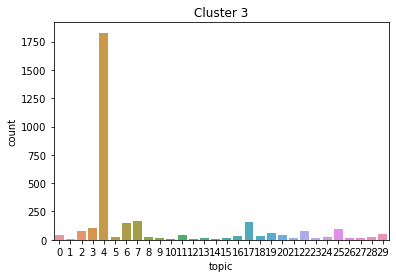

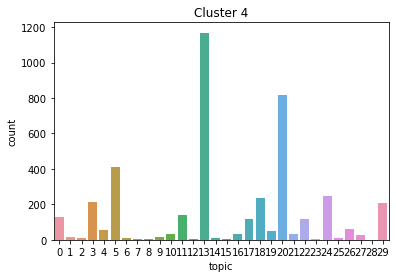

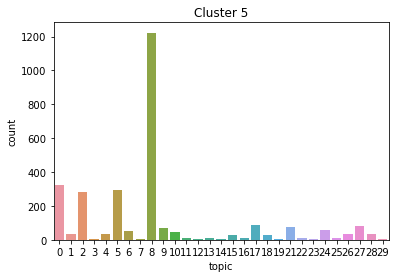

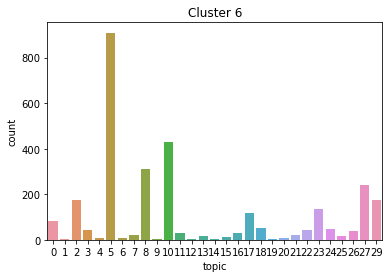

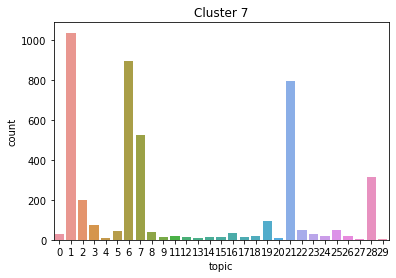

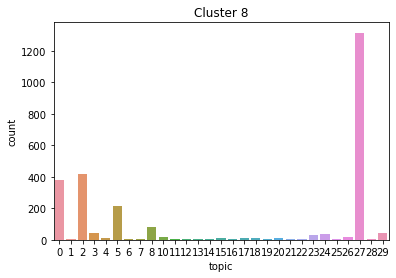

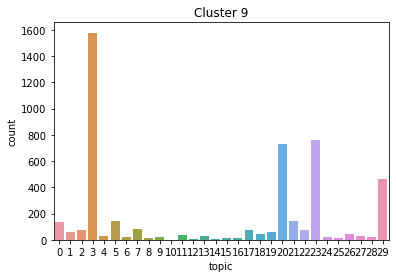

In [346]:
import seaborn as sns
for i in range(10):
    plt.figure()
    plt.title(f'Cluster {i}')
    sns.countplot(x='topic', data=kmeans_df[kmeans_df['cluster']==i])
    plt.show()

In [334]:
kmeans_df.head()

cluster  topic
0        4     18
1        6      7
2        4     20
3        9      5
4        6     29

In [286]:
KMeans_titles(clusters, 10)

Cluster 0
Dengue Fever and How to Predict It
Using mlr for Machine Learning in R: A Step By Step Approach for Decision Trees
But what will the (k-nearest) neighbors think?
Decision Tree Classifier and Cost Computation Pruning using Python
Predicting Formula 1 results with Elo Ratings
Predict Who Survived the Titanic Disaster
Interpretability: Cracking open the black box — Part II
Predicting the probability of SARS CoV-2 result using Multiple Logistic Regression in R and Python
11 Evaluation Metrics Data Scientists Should Be Familiar with— Lessons from A High-rank Kagglers’ New Book
Random forests — An ensemble of decision trees


Cluster 1
tSNE simplified
Space Science with Python — Bright Dots in the Dark Sky
Individual Gain vs the Common Good: Tragedy of the Commons with AI Players
Simulated Annealing and the Eight Queen Problem
Understanding Adam : how loss functions are minimized ?
Memoization in Python: The Essence of Dynamic Programming
Introduction to Reinforcement Learning
Prog

In [179]:
Counter(clusters)

Counter({5: 3550,
         8: 2866,
         3: 3182,
         7: 3296,
         9: 4271,
         2: 4845,
         4: 2620,
         1: 3687,
         0: 2859,
         6: 2745})

In [37]:
# Calculate Centroids
centroids = []
scores = []

for i in np.unique(clusters):
    centroids.append(np.mean(train[clusters == i], axis=0))
for neighbors in range(100, 3000, 100):
    current_groups = []
    labels = []
    for label, centroid in enumerate(centroids):
        current_vecs = model.docvecs.most_similar(positive=[centroid], topn=neighbors)
        labels.extend(len(current_vecs) * [label])
        for vec, _ in current_vecs:
            current_groups.append(model.docvecs[vec])
    labels = np.array(labels)
    sample_score = silhouette_samples(X=current_groups, labels=labels.reshape(-1,1), metric='cosine')
    average_score = np.mean(sample_score)
    scores.append(average_score)
    print(f"The average silhouette score for {neighbors} clusters is {average_score}")
# Find N similar documents
# Calculate Silho
# Increment by 100 neighbors 
# Calculate Silhouette sample scores 


The average silhouette score for 100 clusters is 0.11487773805856705
The average silhouette score for 200 clusters is 0.11248175799846649
The average silhouette score for 300 clusters is 0.10737739503383636
The average silhouette score for 400 clusters is 0.10369330644607544
The average silhouette score for 500 clusters is 0.09921162575483322
The average silhouette score for 600 clusters is 0.0951492115855217
The average silhouette score for 700 clusters is 0.0907536968588829
The average silhouette score for 800 clusters is 0.08664635568857193
The average silhouette score for 900 clusters is 0.0829595997929573
The average silhouette score for 1000 clusters is 0.07931330800056458
The average silhouette score for 1100 clusters is 0.07606801390647888
The average silhouette score for 1200 clusters is 0.07291847467422485
The average silhouette score for 1300 clusters is 0.06976600736379623
The average silhouette score for 1400 clusters is 0.06677062064409256
The average silhouette score for

Text(0, 0.5, 'Siilhouette Score')

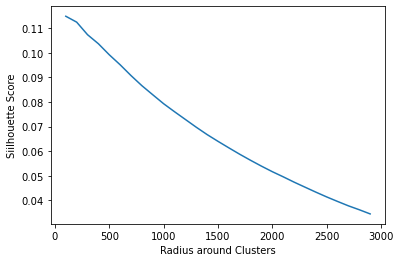

In [38]:
plt.plot(list(range(100, 3000, 100)), scores)
plt.xlabel('Radius around Clusters')
plt.ylabel('Siilhouette Score')

The average silhouette score is 0.03519587591290474


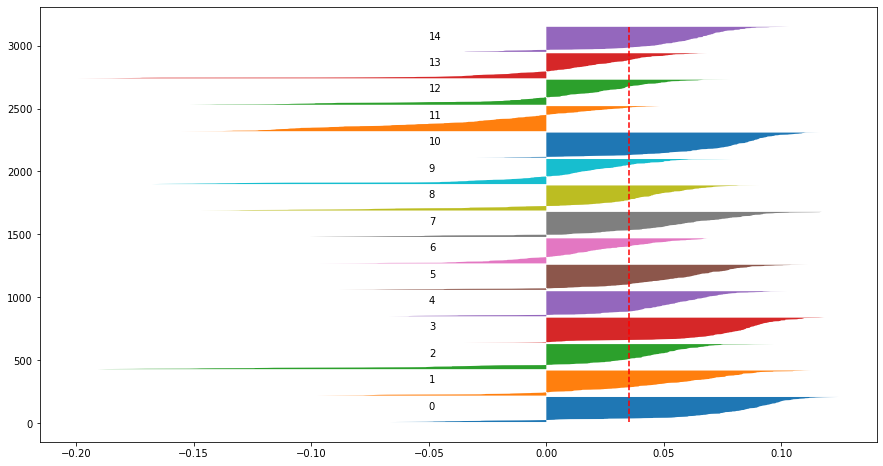

In [197]:
plot_silhouette(current_groups, labels)

In [12]:
X = train[30000:]

In [21]:
silhouette_score(X, labels.reshape(-1,1), 'euclidean')

0.006306262

In [19]:
clusters

array([0, 2, 0, ..., 0, 1, 0])

# HAC

[Scipy HAC Tutorial](https://joernhees.de/blog/2015/08/26/scipy-hierarchical-clustering-and-dendrogram-tutorial/#Plotting-a-Dendrogram)

In [ ]:
from sklearn.cluster import AgglomerativeClustering

In [218]:
ac = AgglomerativeClustering(affinity='cosine', n_clusters=None, distance_threshold=0, linkage='average')

In [219]:
ac_dendro = ac.fit(train)

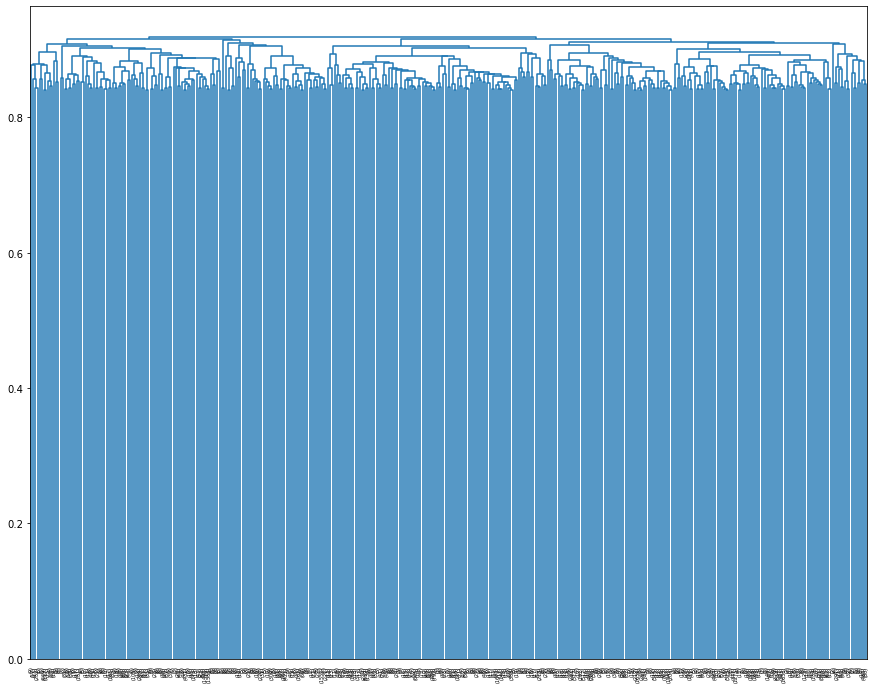

In [224]:
plt.figure(figsize=(15, 12))

dendro_kwargs = {'truncate_mode':'lastp', 'p':400, 'leaf_rotation':90}
plot_dendrogram(ac_dendro, **dendro_kwargs)

In [229]:
# Try with distance threshold of 0.8
ac = AgglomerativeClustering(affinity='cosine', n_clusters=None, distance_threshold=0.9, linkage='average')
ac08 = ac.fit(train)

In [233]:
len(np.unique(ac08.labels_))

19

In [234]:
Counter(ac08.labels_)

Counter({1: 8497,
         15: 6730,
         2: 8166,
         5: 3329,
         4: 4242,
         8: 716,
         0: 1259,
         16: 633,
         7: 1071,
         12: 341,
         11: 15,
         3: 375,
         13: 33,
         9: 11,
         14: 7,
         6: 136,
         18: 15,
         10: 45,
         17: 2})

In [240]:
np.mean(silhouette_samples(train, ac08.labels_, metric='cosine'))

-0.0012682532

In [246]:
def show_labeled_titles(topic_labels, n_to_show=10):
    for label in np.unique(topic_labels):
        current_titles = np.random.choice([title for title in titles_[topic_labels==label]], n_to_show)
        print(f"\nTopic {label}:\n" + '\n'.join(current_titles))

In [251]:
show_labeled_titles(ac08.labels_)


Topic 0:
Formalization of a Reinforcement Learning Problem
Markov Chain Analysis and Simulation using Python
A Simple Introduction To Data Structures: Part One – Linked Lists
Should We Adapt Infrastructure for Future Technology?
GPU Optimized dynamic programming
Linked Lists vs. Arrays
Reinforcement Learning Part 3: Practical Reinforcement Learning
Q-Bay: Explaining Q-Learning with Simulated Auctions
Function Approximation in Reinforcement Learning
Solve sudokus automatically

Topic 1:
A Typology of Data Relationships
Bollinger Bands Statistics in Trading
Do Female College Graduates Earn Less?
NGBoost Explained
Python for Finance: Dash by Plotly
How Can We Impact Well-Being?
Ensemble Learning case study: Running XGBoost on Google Colab free GPU
A Guide to A/B Testing — How to Formulate, Design and Interpret
Linear Algebra and Probability Theory Review for ML
Linear Regression made EASY!

Topic 2:
Supercharged Excel for startup analytics with PowerBI
Identifying regional differences of

In [252]:
# Using Hierarchial Clustering with Cosine

In [134]:
from scipy.cluster.hierarchy import linkage, dendrogram

In [210]:
linkage_mat = linkage(train, metric='cosine', method='ward')

ValueError: Method 'ward' requires the distance metric to be Euclidean

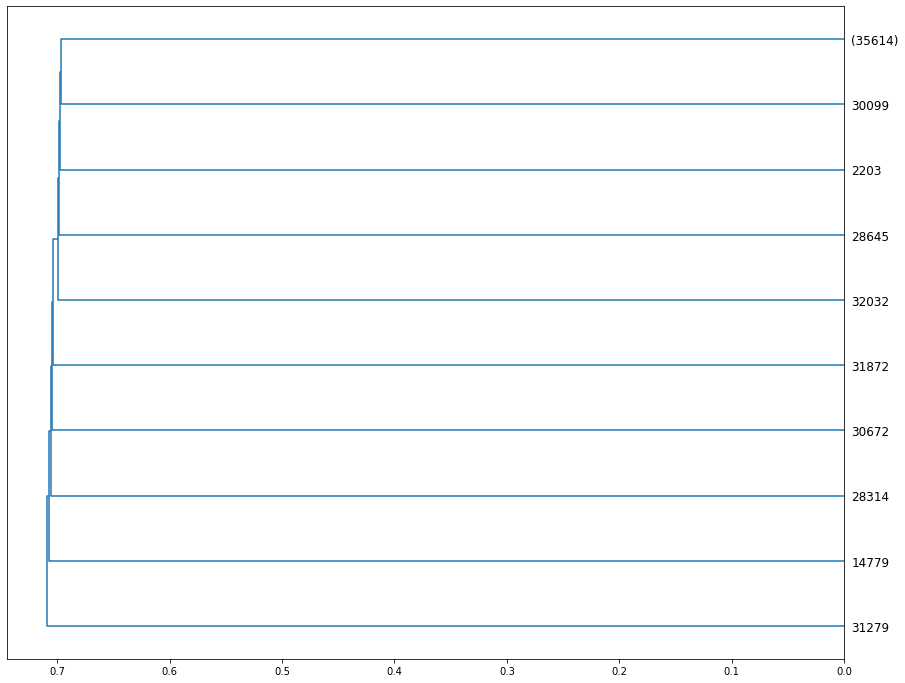

In [206]:

dendrogram(
    Z=linkage_mat,
    truncate_mode='lastp',
    p=10, 
    leaf_rotation=0,
    orientation='left',
    show_leaf_counts=True,
    )

plt.show()

In [144]:
linkage_mat.shape

(35622, 4)

In [209]:
train.shape

(35623, 300)

In [185]:
train

array([[ 0.8678422 , -0.7729198 , -1.7144078 , ...,  0.8993643 ,
        -1.3362492 , -0.81754434],
       [ 1.8948376 ,  0.9556193 , -0.38518238, ...,  0.78039443,
        -0.03074524,  0.517944  ],
       [-0.27679238, -1.551999  , -1.5073544 , ...,  0.5314689 ,
         1.199425  , -0.2941415 ],
       ...,
       [-1.2110385 ,  1.9479507 , -1.3497777 , ...,  0.8447146 ,
        -1.8551941 , -1.5033875 ],
       [ 0.5370833 , -0.3311396 ,  0.03573832, ...,  0.80008775,
         1.4172355 , -1.2789075 ],
       [ 0.44837737,  1.3160225 , -0.04836641, ...,  2.203016  ,
         0.30763108, -1.9146214 ]], dtype=float32)